### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data


### 1. Importing your libraries and data

In [751]:
# Importing libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [752]:
# Defining a path for importing/exporting
path = r'/Users/peterguan/Citi Bike Analysis'

In [753]:
# Importing ZILLOW dataset from QUANDL
zillow = pd.read_csv(r'/Users/peterguan/Citi Bike Analysis/02 Data/Original Data/ZILLOW-DATA.csv', index_col = False)

In [754]:
# Checking the top 5 rows
zillow.head()

indicator_id  region_id        date          value
0         ZSFH      99999  2024-07-31  486230.166077
1         ZSFH      99999  2024-06-30  485893.210056
2         ZSFH      99999  2024-05-31  484599.091201
3         ZSFH      99999  2024-04-30  481777.608669
4         ZSFH      99999  2024-03-31  480423.651093

In [755]:
# Checking the dimensions of the dataset
zillow.shape

(10000, 4)

### 2. Subsetting, wrangling, and cleaning time-series data

In [757]:
# Created a subset to show only 'region_id' filtered to 99959
zillow_filtered = zillow.loc[(zillow['region_id'] == 99959)]

In [758]:
zillow_filtered.head()

indicator_id  region_id        date          value
9908         ZSFH      99959  2024-07-31  575657.995406
9909         ZSFH      99959  2024-06-30  574448.935814
9910         ZSFH      99959  2024-05-31  572745.618161
9911         ZSFH      99959  2024-04-30  569233.762367
9912         ZSFH      99959  2024-03-31  566255.140866

In [759]:
# Converted 'date' to datetime format
zillow_filtered['date'] = pd.to_datetime(zillow_filtered['date'])

In [760]:
# Checking if the conversion was successful 
zillow_filtered.dtypes

indicator_id            object
region_id                int64
date            datetime64[ns]
value                  float64
dtype: object

In [761]:
# Group by 'date' and calculate the mean value for each date
zillow_plot = zillow_filtered.groupby('date')['value'].mean().reset_index()

In [762]:
zillow_plot.head()

date          value
0 2016-12-31  315427.251855
1 2017-01-31  318551.305596
2 2017-02-28  321684.047119
3 2017-03-31  324828.631501
4 2017-04-30  327998.635842

In [763]:
# Importing datetime library

from datetime import datetime

zillow_plot['datetime'] = pd.to_datetime(zillow_plot['date']) # Create a datetime column from "date"
zillow_plot = zillow_plot.set_index('datetime') # Set the datetime as the index of the dataframe
zillow_plot.drop(['date'], axis=1, inplace=True) # Drop the "date" column
zillow_plot.head()

value
datetime                 
2016-12-31  315427.251855
2017-01-31  318551.305596
2017-02-28  321684.047119
2017-03-31  324828.631501
2017-04-30  327998.635842

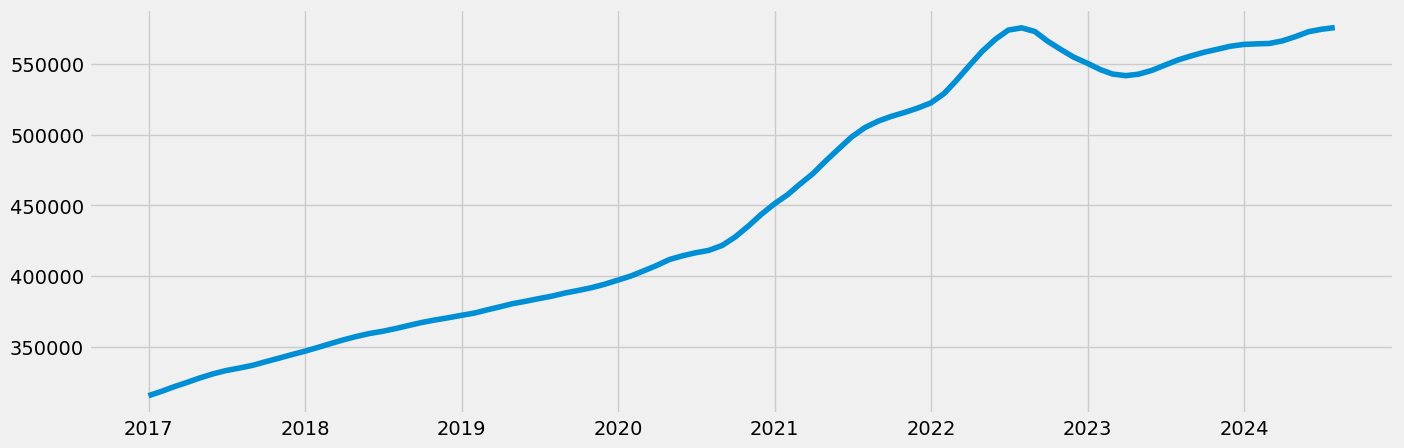

In [764]:
# Plotting the data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(zillow_plot)

In [765]:
# Checking for missing values

zillow_plot.isnull().sum() 

value    0
dtype: int64

In [766]:
# Checking for duplicates

dups = zillow_plot.duplicated()
dups.sum()

# No dups

0

### 3. Time-series analysis: decomposition

In [768]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(zillow_plot, model='additive')

In [769]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

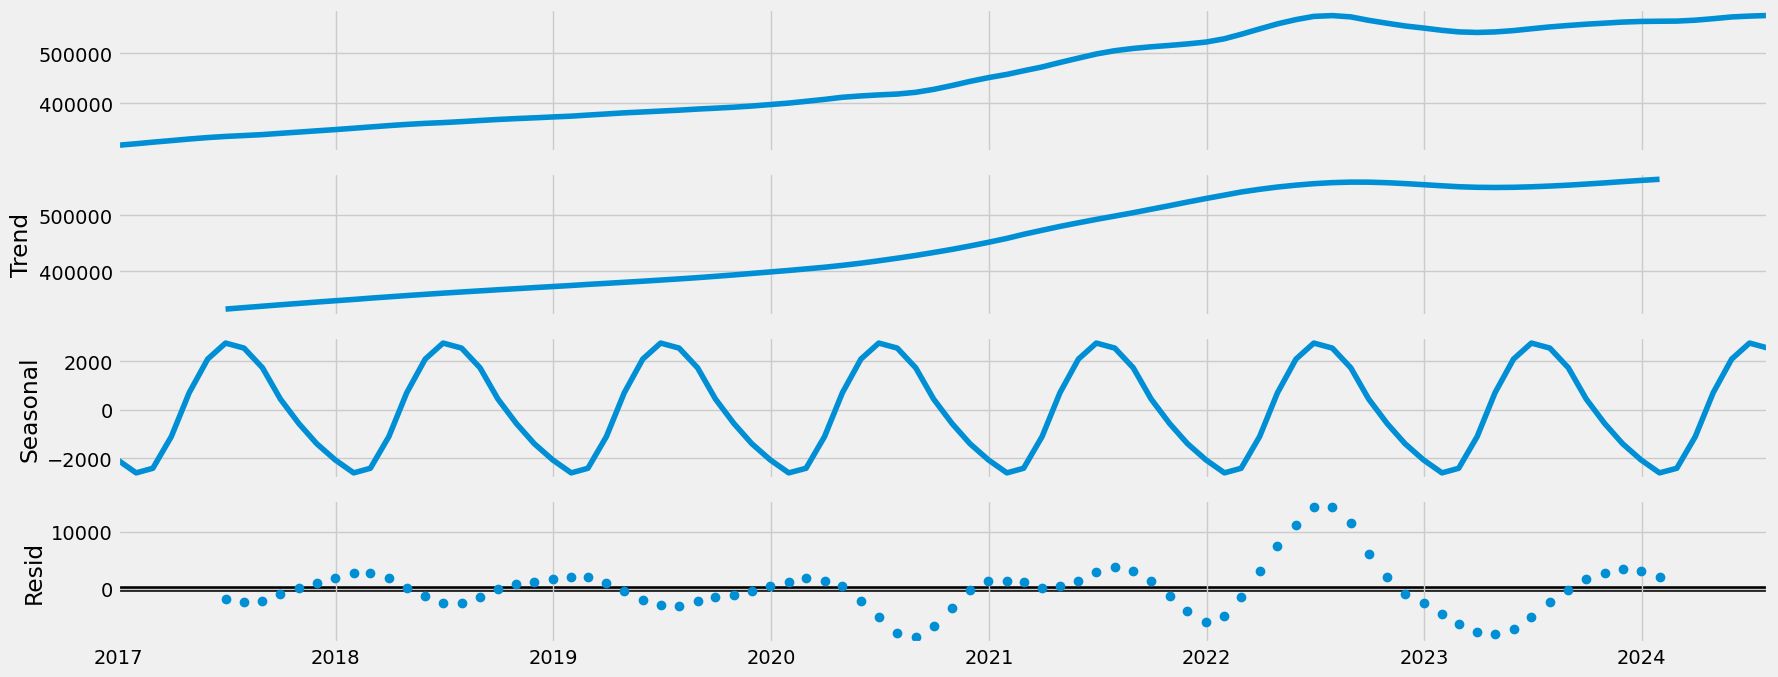

In [770]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [772]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(zillow_plot['value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.877298
p-value                         0.795356
Number of Lags Used            11.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


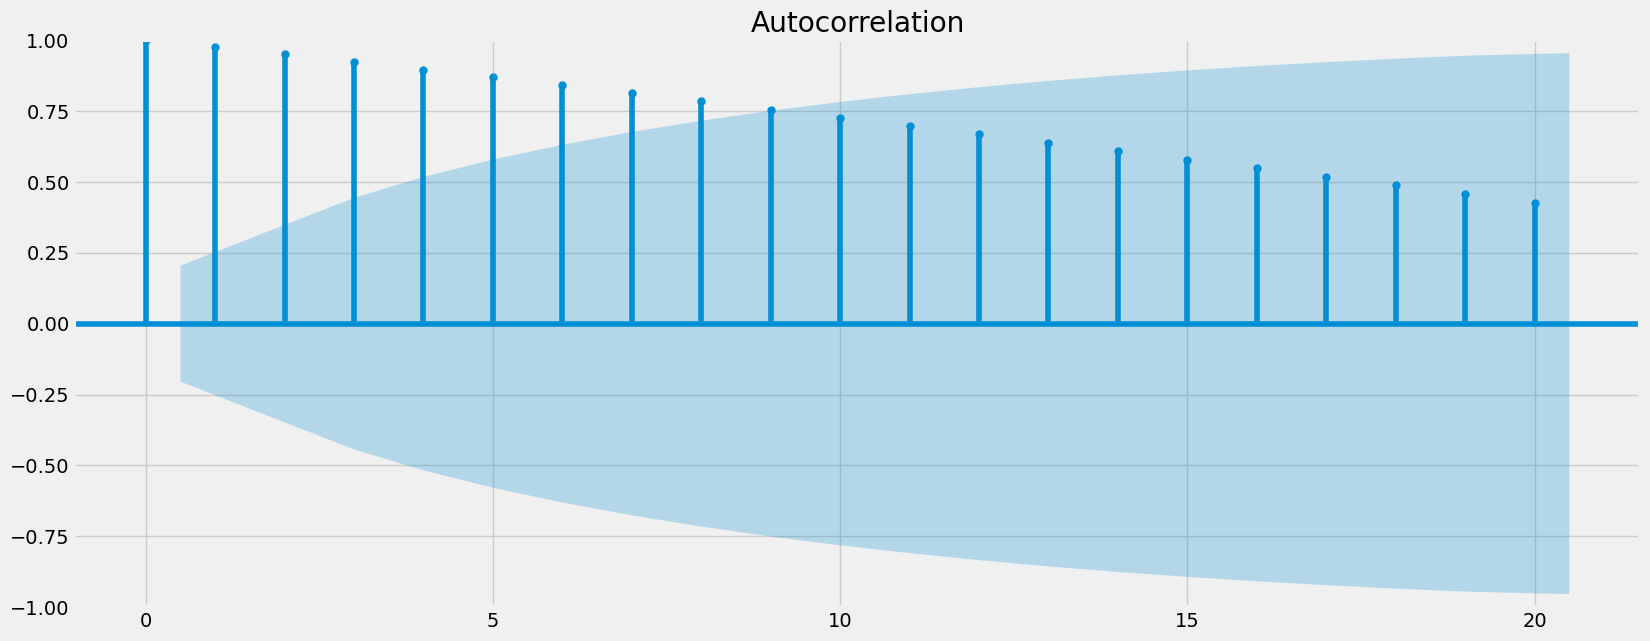

In [773]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(zillow_plot)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [775]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = zillow_plot - zillow_plot.shift(1)

In [776]:
# Checking for duplicates

dups_diff = data_diff.duplicated()

dups_diff

datetime
2016-12-31    False
2017-01-31    False
2017-02-28    False
2017-03-31    False
2017-04-30    False
              ...  
2024-03-31    False
2024-04-30    False
2024-05-31    False
2024-06-30    False
2024-07-31    False
Length: 92, dtype: bool

In [777]:
# Removing the duplicates
data_diff.dropna(inplace = True)

In [778]:
data_diff.head()

value
datetime               
2017-01-31  3124.053741
2017-02-28  3132.741523
2017-03-31  3144.584382
2017-04-30  3170.004341
2017-05-31  2917.383868

In [779]:
data_diff.columns

Index(['value'], dtype='object')

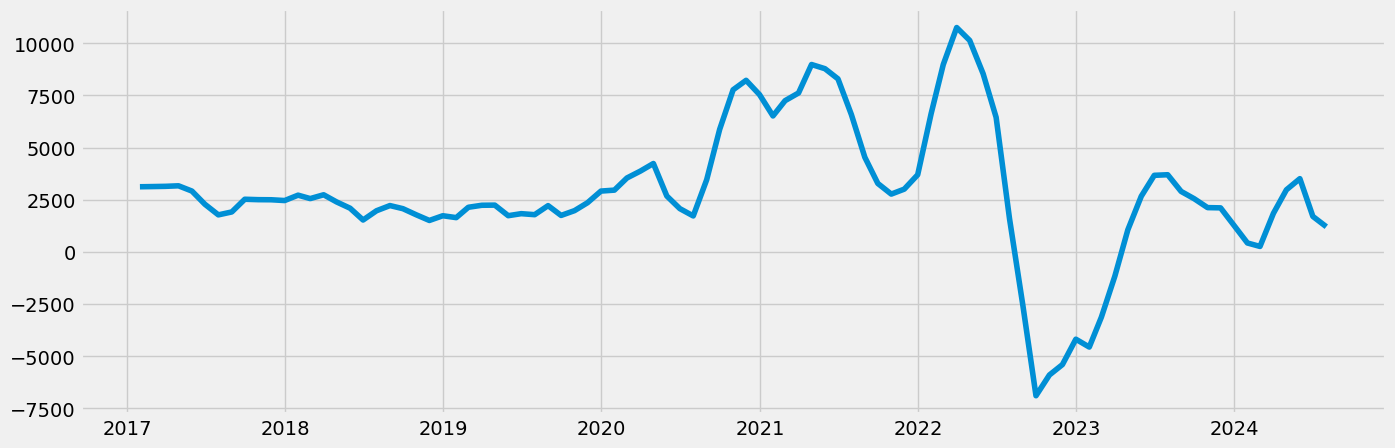

In [780]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [781]:
# Running the dickey fuller test again
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.929245
p-value                         0.318431
Number of Lags Used            10.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


##### Data is NOT stationary. Test statistic is greater than the Critical Value (10%) and p-value is > 0.05. Will need another round of differencing.

#### Round 2 of Differencing

In [784]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff_2 = data_diff - data_diff.shift(1)

In [785]:
# Removing the duplicates
data_diff_2.dropna(inplace = True)

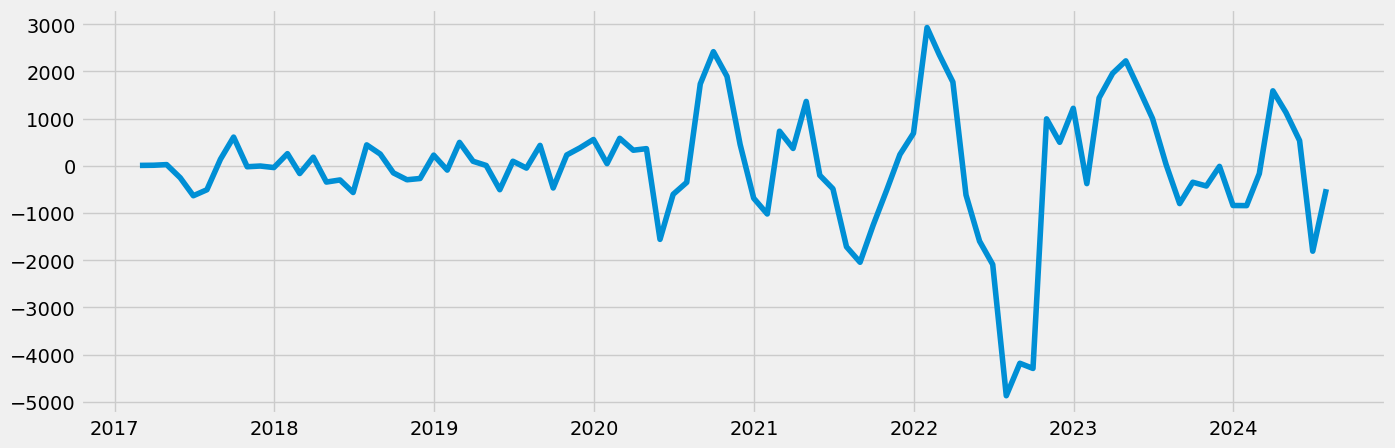

In [786]:
# Ploting the time series to see what the effect of the differencing
plt.figure(figsize=(15,5), dpi = 100)
plt.plot(data_diff_2)

In [787]:
# Running the dickey fuller test again
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.561660
p-value                         0.006538
Number of Lags Used            11.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


##### Data is finally stationary. Test statistic is smaller than the Critical Value (10%) and the p-value is < 0.05.

In [789]:
# Checking the data's autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff_2)
plt.show()